# Working up algorithm based on [Schuster _et al_ (2000)](https://www.nature.com/articles/nbt0300_326), [Schuster _et al_ (2002)](https://link.springer.com/article/10.1007/s002850200143)

- Use glycolysis + PPP, as in the paper (though stopping at PEP)
- Don't worry about efficiency yet, just get a feel for the algorithm
- Results won't be identical to Schuster because system and boundaries are different, but it should be reconcilable

In [1]:
from importlib.resources import files
import ipywidgets as widgets
import json
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import scipy.linalg
from IPython.display import SVG, display

from mosmo.knowledge import kb
from mosmo.model import KbEntry, Molecule, Reaction, Pathway, ReactionNetwork
from mosmo.preso.escher import escher_map
import mosmo.preso.escher.pw as pw_files
from mosmo.calc import fba_gd

KB = kb.configure_kb()

def reaction_formula(reaction):
    def reactant_term(reactant, count):
        label = reactant.label
        count = abs(count)
        if count == 1:
            return label
        else:
            return f'{count} {label}'
    
    lhs = [reactant_term(reactant, count) for reactant, count in reaction.stoichiometry.items() if count < 0]
    rhs = [reactant_term(reactant, count) for reactant, count in reaction.stoichiometry.items() if count > 0]
    
    arrow = ' <=> ' if reaction.reversible else ' => '
    
    return ' + '.join(lhs) + arrow + ' + '.join(rhs)

def mode_formula(network, mode):
    parts = []
    for reaction, coeff in zip(network.reactions.labels(), mode):
        if coeff == -1:
            parts.append('-')
        elif coeff < 0:
            parts.append(f'- {-coeff}')
        elif coeff == 1:
            if parts:
                parts.append('+')
        elif coeff > 0:
            if parts:
                parts.append(f'+ {coeff}')
            else:
                parts.append(f'{coeff}')
        
        if coeff:
            parts.append(reaction)
    
    return ' '.join(parts)

## Define the network

- Slightly modified from Schuster _et al_, but maintaining the same structure and behavior

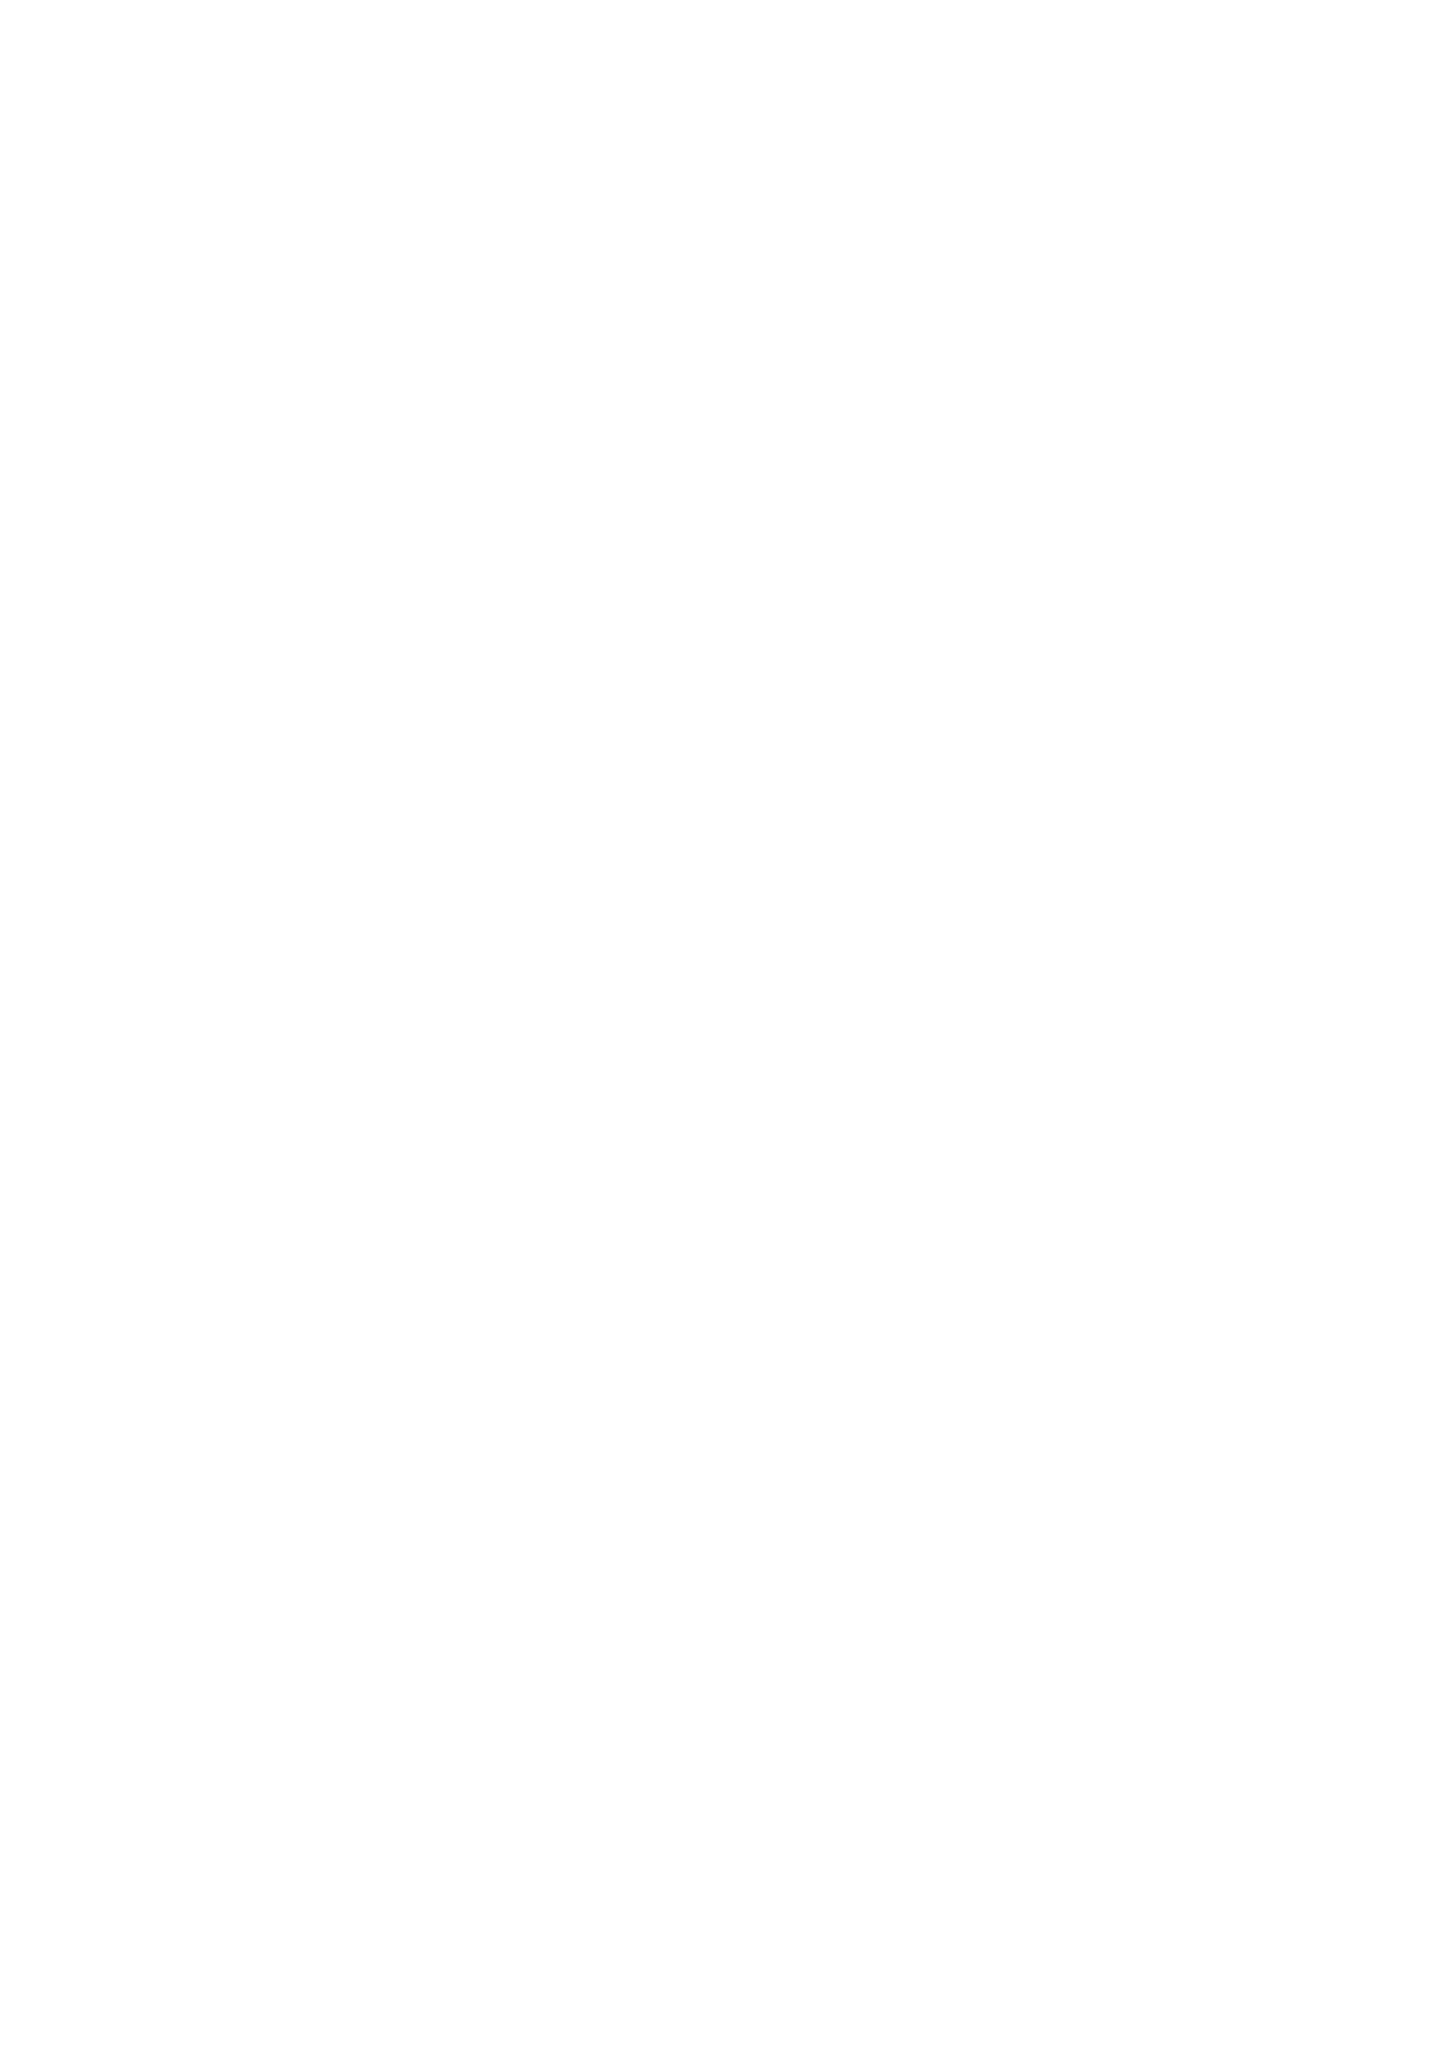

In [2]:
# KB pathways and metabolites for convenience
glycolysis = KB.find(KB.pathways, 'glycolysis')[0]
ppp = KB.find(KB.pathways, 'pentose phosphate')[0]

g6p = KB('Glc.D.6P')
pep = KB('pep')
r5p = KB('Rib.D.5P')
# e4p = KB('Ery.D.4P')

amp = KB('amp')
adp = KB('adp')
atp = KB('atp')
nad = KB('nad.ox')
nadh = KB('nad.red')
nadp = KB('nadp.ox')
nadph = KB('nadp.red')
pi = KB('pi')
h2o = KB('h2o')
co2 = KB('co2')
proton = KB('h+')


# Build the network, but stop at PEP. We'll treat the PEP-pyruvate-acCoA system separately. Also skip E-D for now (minor?)
# TODO: reflect these choices in the KB pathway objects.
exclude = ['pyk', 'pps', 'pdh']
network = ReactionNetwork(r for r in glycolysis.steps + ppp.steps if r.id not in exclude)

# No specific reaction to consume R5P, just treat it as external. Also, we do not ignore water and protons.
bounds = {r5p, co2, nadp, nadph, pep, nad, nadh, pi, amp, adp, atp, g6p, h2o, proton}

scale = escher_map.Scale({0.: ("#eeeeee", 3), 6.: ("#1f77cc", 50)}, use_abs=True)
map_json = json.loads(files(pw_files).joinpath('glycolysis_ppp.json').read_text())
diag = escher_map.EscherMap(map_json, width="6in", reaction_scale=scale)
SVG(diag.draw(reaction_data={rxn_id: 1 for rxn_id in network.reactions.labels()}))

## Approach 1

- Filter S matrix to internal metabolites
- No additional simplifications (e.g. collapsing linear reaction chains)
- PFK and FBP are explicitly irreversible; all others are reversible
- Take reactions as written, e.g. PGK and GPMM run the 'wrong' way, so e.g. their flux will be negative for textbook glycolysis

The algorithm works over iterations, where iteration j ensures the first j metabolites are
at steady state for all flux modes, and all flux modes are elemental at least with respect to those metabolites.


In [3]:
def build_internal_system(network, bounds):
    """Returns S matrix with rows for internal (non-bounds) metabolites only."""
    intermediates = [met not in bounds for met in network.reactants]
    return network.s_matrix[intermediates].astype(int)

def sort_tableau(tableau, j):
    # Existing modes that already satisfy steady state j will be part of the next tableau. Others will either be merged or dropped.
    elementary = []
    pending = []
    for mode, reversible, zeros in tableau:
        if mode[j] == 0:
            elementary.append((mode, reversible, zeros))
        else:
            pending.append((mode, reversible, zeros))
    return elementary, pending

def generate_candidates(pending, j):
    # All pending mode pairs are merge candidates, unless they violate irreversibility.
    candidates = []
    for i, (mode_i, reversible_i, zeros_i) in enumerate(pending):
        for mode_m, reversible_m, zeros_m in pending[i+1:]:
            # Put a reversible mode second if possible, so we can always multiply the first by a positive number
            if reversible_m:
                candidates.append((mode_i, mode_m, reversible_i and reversible_m, zeros_i & zeros_m))
            elif reversible_i:
                candidates.append((mode_m, mode_i, reversible_i and reversible_m, zeros_i & zeros_m))

            # Otherwise we can still combine them, if they have opposite stoichiometry
            elif mode_i[j] * mode_m[j] < 0:
                candidates.append((mode_i, mode_m, False, zeros_i & zeros_m))
    return candidates

def merge_modes(mode_i, mode_m, reversible, j, num_rxns):
    # All integer arithmetic. We want integer scaling in simplest form.
    multiple = int(np.lcm(mode_i[j], mode_m[j]))
    # scale_i is always positive
    scale_i = int(multiple / abs(mode_i[j]))
    # scale_m satisfies scale_i * mode_i[j] + scale_m * mode_m[j] = 0. 
    scale_m = -int(scale_i * mode_i[j] / mode_m[j])

    # Combine modes, and reduce to simplest integers.
    mode = scale_i * mode_i + scale_m * mode_m
    mode = (mode / np.gcd.reduce(mode)).astype(int)
    
    # Determine the actual new zeros set on the moerged mode.
    zeros = set(np.nonzero(mode[-num_rxns:] == 0)[0])
    
    # Mostly esthetic, but prefer original reaction direction for reversible modes
    if reversible:
        involved = num_rxns - len(zeros)
        forward = np.nonzero(mode[-num_rxns:] > 0)[0].shape[0]
        if forward * 2 < involved:
            mode = -mode

    return mode, reversible, zeros

def process_candidates(candidates, modes, j, num_rxns):
    # Compare candidates against all other elementary modes, based on the non-subset zeros test.
    for i, (mode_i, mode_m, reversible, zeros) in enumerate(candidates):
        passing = True
        for _, _, other_zeros in modes:
            if zeros <= other_zeros:  # subset or equal
                # print(f'  {mode_i} + {mode_m} Fails because {zeros} <= {other_zeros}')
                passing = False
                break

        # If the candidate survived, keep it. Other candidates must now compare against this new mode too.
        if passing:
            modes.append(merge_modes(mode_i, mode_m, reversible, j, num_rxns))
    
    return modes

# def elementary_modes(network, bounds):
def elementary_modes(s_matrix, reversibilities):
    # tableau = init_tableau(network, bounds)
    num_mets, num_rxns = s_matrix.shape
    modes = list(np.concatenate([s_matrix, np.eye(num_rxns, dtype=int)]).T)
    tableau = [(mode, reversible, set(np.nonzero(mode[-num_rxns:] == 0)[0]))
                for mode, reversible in zip(modes, reversibilities)]

    for j in range(num_mets):
        modes, pending = sort_tableau(tableau, j)
        candidates = generate_candidates(pending, j)
        # TODO: optimization based on cardinality of merged zeros set, per Urbanczik & Wagner (2004)?
        
        tableau = process_candidates(candidates, modes, j, num_rxns)
        
    modes = []
    rev = []
    for mode, reversible, zeros in tableau:
        modes.append(mode[-num_rxns:])
        rev.append(reversible)
    
    return np.array(modes, dtype=int).T, rev

In [4]:
%%time
modes, rev = elementary_modes(build_internal_system(network, bounds), (reaction.reversible for reaction in network.reactions))

CPU times: user 10.3 ms, sys: 142 μs, total: 10.4 ms
Wall time: 10.3 ms


### Reaction usage and net reaction per elementary mode

In [5]:
def show_modes(network, modes, rev):
    s_elementary = (network.s_matrix.astype(int) @ modes)
    net_reactions = []
    for i, (mode, reversible) in enumerate(zip(s_elementary.T, rev)):
        stoich = {}
        for met, count in zip(network.reactants, mode):
            if count != 0:
                stoich[met] = count

        net_reaction = Reaction(id=f'mode{i}', name=f'Elementary Mode {i}', stoichiometry=stoich, reversible=reversible)
        net_reactions.append(net_reaction)

    w = f'{160 + modes.shape[1] * 8:d}px' if modes.shape[1] < 80 else '100%'
    mode_select = widgets.IntSlider(
        value=0,
        min=0,
        max=modes.shape[1] - 1,
        description='Mode',
        continuous_update=True,
        readout=True,
        layout={'width': w}
    )
    mode_fluxes = widgets.Text(description='flux ratios', layout={"width": "99%"})
    mode_net = widgets.Text(description='net reaction', layout={"width": "99%"})
    map_json = json.loads(files(pw_files).joinpath('glycolysis_ppp.json').read_text())
    diag = escher_map.EscherMap(map_json, width="100%", reaction_scale=scale)
    diag_canvas = widgets.Output()

    def show_mode(change):
        mode = mode_select.value
        mode_fluxes.value = mode_formula(network, modes.T[mode])
        mode_net.value = reaction_formula(net_reactions[mode])
        # Update the pathway diagram
        svg = diag.draw(reaction_data={r.label: v for r, v in zip(network.reactions, modes.T[mode])})
        diag_canvas.clear_output(wait=True)
        with diag_canvas:
            display(SVG(svg))

    mode_select.observe(show_mode, names='value')
    show_mode(None)

    return widgets.VBox([mode_select, mode_fluxes, mode_net, diag_canvas], layout={"width": "6in"})

In [6]:
show_modes(network, modes, rev)

# Try to make the network identical to Schuster et al (2000)

In [7]:
# Extend to pyruvate and to R5Pex.
r5p_ex = Molecule(id='r5p_ex', name='Incorporated R5P', shorthand='R5Pex')
prs_deob = Reaction(
    id='prs_deob',
    name='R5P nucleotide incorporation',
    stoichiometry={
        r5p: -1,
        r5p_ex: +1
    },
    reversible=False)

#  *** Pyk is irreversible, but the wrong way! Semanitics of the name 'pyruvate *kinase*' aside, define the reaction as strictly PEP + ADP -> pyruvate + ATP ***
pyk = KB.get(KB.reactions, 'pyk')
pyk_irr = Reaction(
    id='pyk_irr',
    name='Glycolytic PYK',
    shorthand='PYK',
    stoichiometry = {met: -count for met, count in pyk.stoichiometry.items()},
    reversible=False,
)

exclude = {'pps', 'pdh', 'pyk'}
network = ReactionNetwork(r for r in glycolysis.steps + ppp.steps + [pyk_irr, prs_deob] if r.id not in exclude)

# We still keep track of protons and water, where they do not. This *shouldn't* make a difference...
pyr = KB('pyr')
bounds = {g6p, pyr, r5p_ex, nad, nadh, nadp, nadph, amp, adp, atp, pi, co2, h2o, proton}

modes, rev = elementary_modes(build_internal_system(network, bounds), (reaction.reversible for reaction in network.reactions))
show_modes(network, modes, rev)

Most correspond to modes as in Schuster _et al_ (2000)
- 0 = G = futile cycle
- 1 = A = textbook glycolysis
- 2 = D = G6P to R5P + CO2
- 3 = E = 5 G6P to 6 R5P
- 5 = F = burn G6P completely to CO2, generating NADPH
- 6 = B = burn G6P half to CO2, half to pyruvate
- 7 = C = burn G6p 1/6 to CO2, the rest to pyruvate

Two extra modes:
- 4 = pure carbon fixation 6 CO2 -> G6P, consuming ATP and NADPH.
- 8 = lesser carbon fixation, G6P + 4 CO2 -> 2 R5P

**Bingo:** the two extra modes use PGLDH (6-phosphogluconate dehydrogenase) in reverse, while Schuster _et al_ treat it as irreversible. eQuilibrator gives its standard ΔG as +10.7 kJ/mol, which is _uphill_, though at cellular concentrations I calculate it at more like -11. So we do expect it to run in the direction given, but it is not impossible that it could go the opposite way under the right conditions.

### Either way, check that making it irreversible reproduces the published result:

In [8]:
#  Replace PGLDH with an irreversible copy.
pgldh = KB.get(KB.reactions, 'pgldh')
pgldh_irr = Reaction(
    id=pgldh.id + '_irr',
    name=pgldh.name,
    shorthand=pgldh.shorthand,
    stoichiometry = pgldh.stoichiometry,
    reversible=False,
)

exclude = {'pps', 'pdh', 'pyk', 'pgldh'}
network = ReactionNetwork(r for r in glycolysis.steps + ppp.steps + [pyk_irr, pgldh_irr, prs_deob] if r.id not in exclude)

# Same bounds as above
bounds = {g6p, pyr, r5p_ex, nad, nadh, nadp, nadph, amp, adp, atp, pi, co2, h2o, proton}
modes, rev = elementary_modes(build_internal_system(network, bounds), (reaction.reversible for reaction in network.reactions))
show_modes(network, modes, rev)

Same 7 elementary modes as in Schuster _et al_ (2000). **Declare success**.

### Reproducibility of elementary modes

- Randomly permute reactions and metabolites, and collect the resulting elementary modes.

In [9]:
%%time
rng = np.random.default_rng()

s_internal = build_internal_system(network, bounds)
reversibilities = np.array([reaction.reversible for reaction in network.reactions])

results = []
for _ in range(1000):
    met_perm = rng.permutation(s_internal.shape[0])
    rxn_perm = rng.permutation(s_internal.shape[1])
    
    # Permute the input matrix by both row and column
    modes, rev = elementary_modes(s_internal[met_perm][:, rxn_perm], reversibilities[rxn_perm])
    
    # Restore the original reaction ordering
    results.append((met_perm, rxn_perm, modes[np.argsort(rxn_perm)], rev))

CPU times: user 2.87 s, sys: 4.25 ms, total: 2.87 s
Wall time: 2.87 s


In [10]:
for i, (_, _, modes, _) in enumerate(results):
    if modes.shape != (19, 7):
        print(i, modes.shape)

Always 7 modes

In [11]:
mode_sorted = []
for _, _, modes, _ in results:
    modes = modes[:, modes[1].argsort()]
    modes = modes[:, modes[0].argsort(kind='stable')]
    mode_sorted.append(modes)
allmodes = np.array(mode_sorted)
allmodes.shape

(1000, 19, 7)

In [12]:
np.mean(allmodes, axis=0)

array([[-5., -2.,  0.,  0.,  0.,  1.,  5.],
       [ 0.,  0.,  0.,  1.,  2.,  1.,  1.],
       [ 1.,  0.,  0.,  1.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  2.,  1.,  1.],
       [ 1.,  0.,  0.,  0., -2., -1., -1.],
       [ 0.,  1.,  0.,  0.,  5.,  2.,  0.],
       [ 0., -1.,  0.,  0., -5., -2.,  0.],
       [ 0., -1.,  0.,  0., -5., -2.,  0.],
       [ 0.,  1.,  0.,  0.,  5.,  2.,  0.],
       [-2., -1., -1.,  0., -1.,  0., -4.],
       [-2., -1.,  0.,  0., -1.,  0.,  2.],
       [ 4.,  2.,  0.,  0.,  2.,  0., -4.],
       [ 6.,  3.,  1.,  0.,  3.,  0.,  0.],
       [ 2.,  1.,  0.,  0.,  1.,  0., -2.],
       [ 2.,  1.,  0.,  0.,  1.,  0., -2.],
       [ 6.,  3.,  1.,  0.,  3.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  5.,  2.,  0.],
       [ 6.,  3.,  1.,  0.,  3.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  6.]])

OK, looks 100% consistent

## Approach 2 - Only a minor variation

- Treat at least some of the boundaries as exchanges rather than external metabolites
- _Should_ give the same result e.g. for FBA
  - Unconstrained dM/dt is the same as an unconstrained exchange via a one-metabolite pseudo-reaction
- But for elementary mode analysis it could matter
  - Keeps the metabolite row of interest in the subsetted S matrix used for the elementary mode algorithm.
    - This could make the difference for a given reaction being included in the analysis at all, e.g. between two metabolites that could both also exchange
  - The exchange could be marked irreversible to restrict to a relevant subset of modes


In [13]:
def augmented_internal_system(network, exchanges, bounds):
    """Returns S matrix with rows for internal and exchanged metabolites only."""
    
    # Append columns ('reactions') with a single entry for each exchange
    exchange_cols = np.zeros((network.shape[0], len(exchanges)), dtype=int)
    for j, met in enumerate(exchanges):
        exchange_cols[network.reactants.index_of(met), j] = 1

    intermediates = [met not in bounds for met in network.reactants]
    s_matrix = np.concatenate([network.s_matrix.astype(int), exchange_cols], axis=1)
    return s_matrix[intermediates]


In [14]:
build_internal_system(network, bounds).shape

(15, 19)

In [15]:
augmented_internal_system(network, {g6p, pyr}, bounds - {g6p, pyr}).shape

(17, 21)

In [16]:
modes, rev = elementary_modes(
    augmented_internal_system(network, {g6p, pyr}, bounds - {g6p, pyr}),
    [reaction.reversible for reaction in network.reactions] + [True, True])

In [17]:
modes.shape

(21, 7)

In [18]:
show_modes(network, modes[:network.shape[1]], rev)

Same